# Useful functions

In [2]:
def mae(predictions, targets):
  return (predictions - targets).abs().sum() / predictions.shape[0]

In [3]:
import yfinance as yf
import pandas as pd
import numpy as np

In [4]:
from statsmodels.tsa.ar_model import AutoReg



## AR function predicting the price at time t using a specified lag
## inputs: comp: company closing stock price, lags, and exog variable (pandas series)
def AR_predict_price(comp, lags, start=100, exog=None):
  summary_table = pd.DataFrame(columns=['Data', 'Pred'])
  predictions = []

  # loop through series to predict each t
  for i in range(start, comp.shape[0]):
    if exog is None:
      model = AutoReg(comp.values[:i], lags=lags)
      fitted = model.fit()
      pred = fitted.forecast()
    else:
      model = AutoReg(comp.values[:i], lags=lags, exog=exog.values[:i])
      fitted = model.fit()
      pred = fitted.forecast(exog=exog.values[:i])
    predictions.append(pred[0])
  summary_table['Data'] = comp.values[start:]
  summary_table['Pred'] = predictions
  summary_table.index = comp.index[start:]
  return summary_table

In [5]:
## AR function predicting the gradient at time t using a speicified lag
## inputs: comp: company closing stock price, lags, and exog variable (pandas series)
def AR_predict_direction(df, lags, start=100, exog=None):
  comp = df.Close
  direction = df.direction
  summary_table = pd.DataFrame(columns=['Data', 'Pred'])
  predictions = []

  # loop through series to predict each t
  for i in range(start, comp.shape[0]):
    if exog is None:
      model = AutoReg(comp.values[:i], lags=lags)
      fitted = model.fit()
      pred = fitted.forecast()
    else:
      model = AutoReg(comp.values[:i], lags=lags, exog=exog.values[:i])
      fitted = model.fit()
      pred = fitted.forecast(exog=exog.values[:i])

    if pred[0] > comp.values[i]:
        pred = 1
    else:
      pred = -1

    predictions.append(pred)

  summary_table['Data'] = direction[start:]
  summary_table['Pred'] = predictions
  summary_table.index = comp.index[start:]

  return summary_table

# Data

In [6]:
aapl = yf.Ticker("AAPL").history(period="24mo")
googl = yf.Ticker("GOOGL").history(period="24mo")
msft = yf.Ticker("MSFT").history(period="24mo")
nvda = yf.Ticker("NVDA").history(period="24mo")
amzn = yf.Ticker("AMZN").history(period="24mo")
sp500 = yf.Ticker("^GSPC").history(period="24mo")
# aapl.describe()

In [7]:
sp500 = yf.Ticker("^GSPC").history(start="2021-09-30", end="2022-09-30")

In [8]:
aapl = yf.Ticker("AAPL").history(start="2021-09-30", end="2022-09-30")
aapl["Tomorrow"] = aapl.Close.shift(-1).copy()
aapl['direction'] = ((aapl['Tomorrow']-aapl['Close']) > 0).astype(int)
aapl['direction'] = aapl['direction'].replace({0:-1})
aapl = aapl.drop(columns=['Dividends', 'Stock Splits'])
aapl.index = pd.to_datetime(aapl.index)
aapl.index = aapl.index.normalize()
aapl = aapl.dropna()

In [9]:
diff1 = aapl.Close - aapl.Tomorrow
diff1.abs().mean()

2.4172511005781563

In [10]:
amzn = yf.Ticker("AMZN").history(start="2021-09-30", end="2022-09-30")
amzn['Tomorrow'] = amzn.Close.shift(-1).copy()
amzn['direction'] = ((amzn['Tomorrow']-amzn['Close']) > 0).astype(int)
amzn['direction'] = amzn['direction'].replace({0:-1})
amzn = amzn.drop(columns=['Dividends', 'Stock Splits'])
amzn.index = pd.to_datetime(amzn.index)
amzn.index = amzn.index.normalize()
amzn = amzn.dropna()

In [11]:
diff2 = amzn.Close - amzn.Tomorrow
diff2.abs().mean()

2.9004740923999317

# Sentiment Data

In [12]:
!pip install eng-spacysentiment

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 8.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 22.5 MB/s eta 0:00:00
  Created wheel for eng-spacysentiment: filename=eng_spacysentiment-2.3.0-py3-none-any.whl size=1342134 sha256=ffcc11c458aaaa37df50f0910eb20940026428a9028f267438ec7f78d0fec581
  Stored in directory: /root/.cache/pip/wheels/c7/85/4a/f6db06d341f4006864e5fa940b473acb2987c8e0111f8a4642
Successfully built eng-spacysentiment
  Attempting uninstall: spacy
    Found existing installation: spacy 3.6.1
    Uninstalling spacy-3.6.1:
      Successfully uninstalled spacy-3.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
en-core-web-sm 3.6.0 requires spacy<3.7.0,>=3.6.0, but you have spacy 3.5.4 which is incompatible.


In [13]:
url = "https://raw.githubusercontent.com/emilwestling/AlgorithmTrading/main/stock_tweets.csv"
tweets = pd.read_csv(url)
tweets.index = tweets.Date
tweets['Stock Name'].value_counts()

TSLA    37422
TSM     11034
AAPL     5056
PG       4089
AMZN     4089
MSFT     4089
NIO      3021
META     2751
AMD      2227
NFLX     1727
GOOG     1291
PYPL      843
DIS       635
BA        399
COST      393
INTC      315
KO        310
CRM       233
XPEV      225
ENPH      216
ZS        193
VZ        123
BX         50
NOC        31
F          31
Name: Stock Name, dtype: int64

In [14]:
import eng_spacysentiment
nlp = eng_spacysentiment.load()


def getSentiment(text):
  sentiment = nlp(text).cats
  max_sent_score = 0.00
  max_sent_category = None

  for category, score in sentiment.items():
      if score > max_sent_score:
          max_sent_score = score
          max_sent_category = category

  if max_sent_category == 'positive':
    return 1
  elif max_sent_category == 'neutral':
    return 0
  return -1

In [15]:
def addSentCol(df, ticker):
  sent_data_comp = tweets.loc[tweets['Stock Name'] == ticker]
  sent_data_comp['Sentiment'] = sent_data_comp['Tweet'].apply(getSentiment).copy()
  sent_data_comp = sent_data_comp.drop(columns=['Tweet', 'Stock Name'])

  # sum up the sentiments for each day
  sent_data_comp.index = pd.to_datetime(sent_data_comp.index, utc=True)
  sent_data_comp.index = sent_data_comp.index.tz_convert('America/New_York')
  sent_data_comp.index = sent_data_comp.index.normalize()
  sent_data_comp = sent_data_comp.groupby(sent_data_comp.index).sum()
  sent_data_comp.index

  merged_df = df.join(sent_data_comp, how='inner')
  return merged_df

In [16]:
aapl = addSentCol(aapl, 'AAPL')
amzn = addSentCol(amzn, 'AMZN')

<ipython-input-15-24370432b8b5>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sent_data_comp['Sentiment'] = sent_data_comp['Tweet'].apply(getSentiment).copy()
<ipython-input-15-24370432b8b5>:10: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sent_data_comp = sent_data_comp.groupby(sent_data_comp.index).sum()
<ipython-input-15-24370432b8b5>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pand

# Data Visualization

In [17]:
print(aapl.Volume.sum()/aapl.shape[0])
print(amzn.Volume.sum()/amzn.shape[0])

88978701.19521913
71984490.03984064


In [18]:
!pip install mplfinance
import mplfinance as mpf


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 1.1 MB/s eta 0:00:00


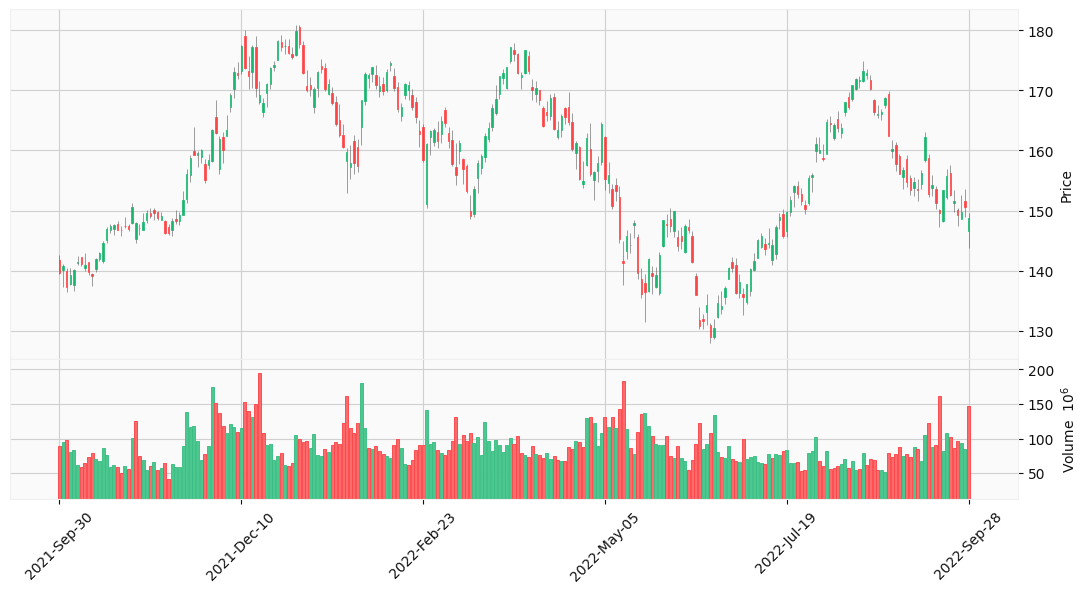

In [19]:
mpf.plot(aapl,type='candle', style='yahoo',volume=True, figsize=(14, 7))

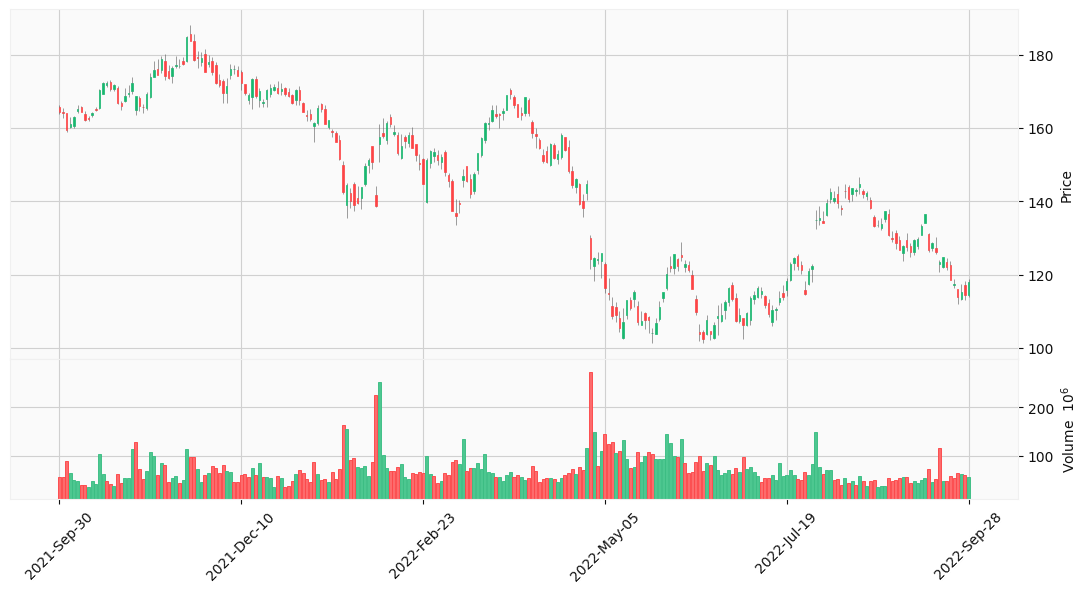

In [20]:
mpf.plot(amzn,type='candle', style='yahoo',volume=True,figsize=(14, 7))

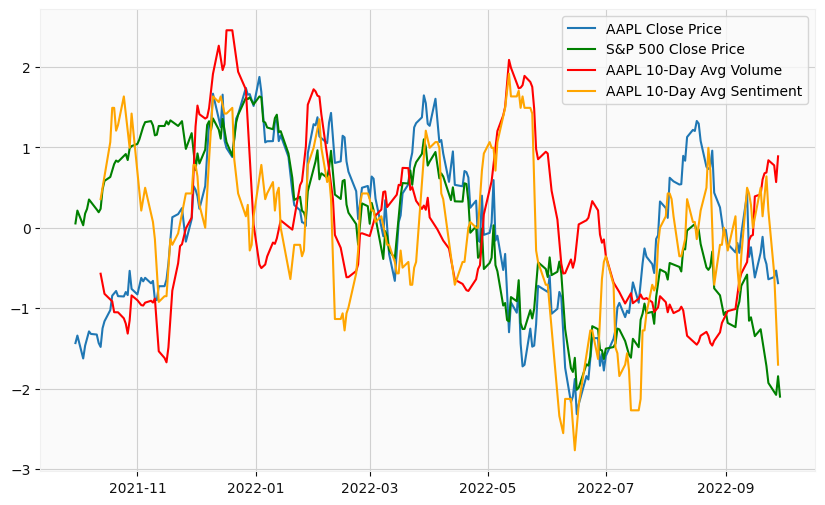

In [21]:
from matplotlib import pyplot as plt

def normalize(x):
  return (x-x.mean())/x.std()

aapl = aapl.sort_index()
plt.figure(figsize=(10, 6))
plt.plot(normalize(aapl['Close']), label='AAPL Close Price')
plt.plot(normalize(sp500['Close']), color='green', label='S&P 500 Close Price')
plt.plot(normalize(aapl['Volume'].rolling(10).mean()), color='red', label='AAPL 10-Day Avg Volume')
plt.plot(normalize(aapl['Sentiment'].rolling(10).mean()), color='orange', label='AAPL 10-Day Avg Sentiment')
plt.legend()

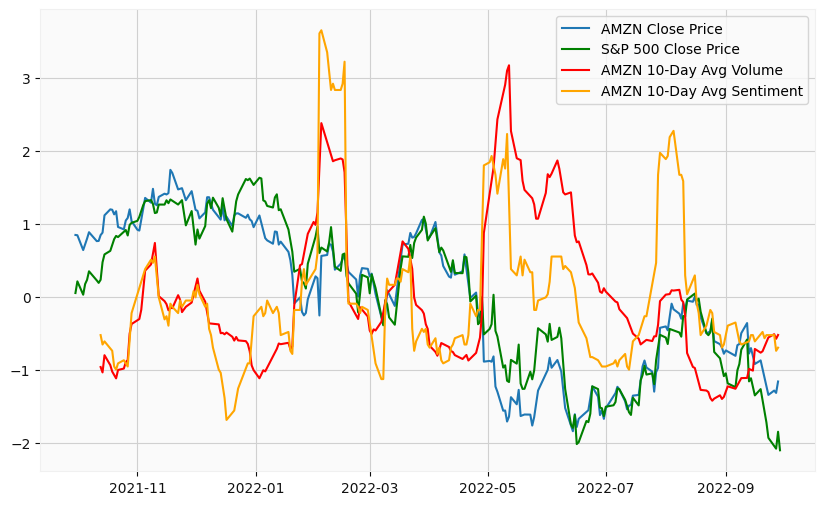

In [22]:
amzn = amzn.sort_index()
plt.figure(figsize=(10, 6))
plt.plot(normalize(amzn['Close']), label='AMZN Close Price')
plt.plot(normalize(sp500['Close']), color='green', label='S&P 500 Close Price')
plt.plot(normalize(amzn['Volume'].rolling(10).mean()), color='red', label='AMZN 10-Day Avg Volume')
plt.plot(normalize(amzn['Sentiment'].rolling(10).mean()), color='orange', label='AMZN 10-Day Avg Sentiment')
plt.legend()

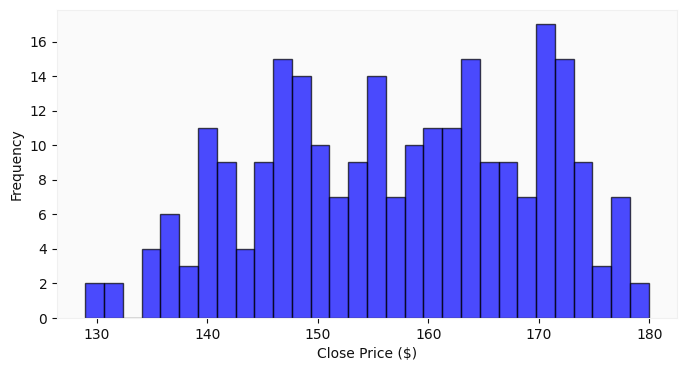

In [23]:
# Plotting the histogram of 'Close' prices
plt.figure(figsize=(8, 4))
plt.hist(aapl['Close'], bins=30, alpha=0.7, color='blue', edgecolor='black')

plt.xlabel('Close Price ($)')
plt.ylabel('Frequency')
plt.grid(False)
plt.show()

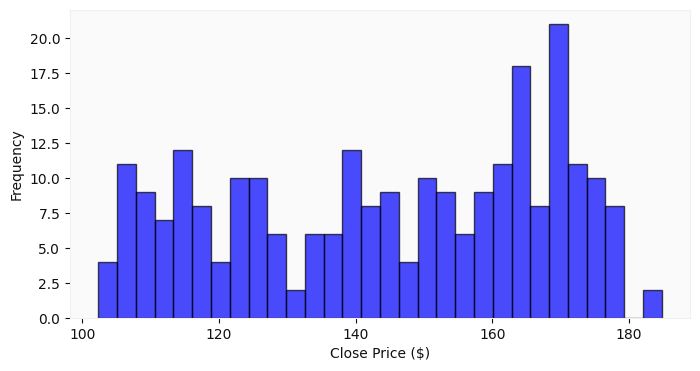

In [24]:
# Plotting the histogram of 'Close' prices
plt.figure(figsize=(8,4))
plt.hist(amzn['Close'], bins=30, alpha=0.7, color='blue', edgecolor='black')

# Adding titles and labels
plt.xlabel('Close Price ($)')
plt.ylabel('Frequency')
plt.grid(False)
plt.show()

In [25]:
t500 = sp500.iloc[:-1]

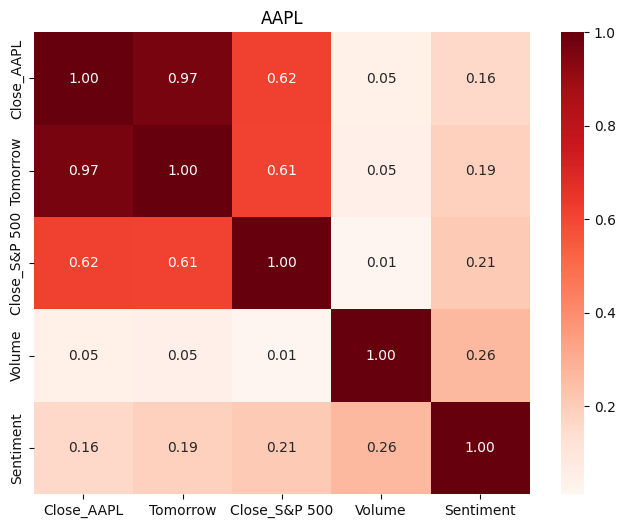

In [26]:
import seaborn as sns

# Plotting the heatmap
plt.figure(figsize=(8, 6))
temp_df = aapl.drop(columns=['direction']).join(t500[['Close']], lsuffix="_AAPL", rsuffix="_S&P 500")
sns.heatmap(temp_df[['Close_AAPL', 'Tomorrow', 'Close_S&P 500', 'Volume', 'Sentiment']].corr().abs(), annot=True, fmt=".2f", cmap='Reds')
plt.title('AAPL')
plt.grid(False)
plt.show()

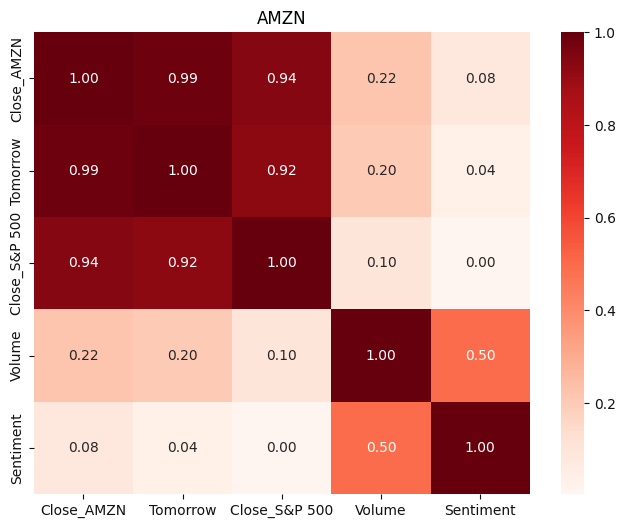

In [27]:
# Plotting the heatmap
temp_df2 = amzn.drop(columns=['direction']).join(t500[['Close']], lsuffix="_AMZN", rsuffix="_S&P 500")
plt.figure(figsize=(8, 6))
sns.heatmap(temp_df2[['Close_AMZN', 'Tomorrow', 'Close_S&P 500', 'Volume', 'Sentiment']].corr().abs(), annot=True, fmt=".2f", cmap="Reds")
plt.title("AMZN")
plt.grid(False)
plt.show()

# Models

In [30]:
def predict_price():

  ls = []
  for i in [10,15,20]:
    aapl_sp500 = AR_predict_price(aapl.Close, i, exog=sp500.Close)
    aapl_vol = AR_predict_price(aapl.Close, i, exog=aapl.Volume)
    aapl_sent = AR_predict_price(aapl.Close, i, exog=aapl.Sentiment)
    aapl_ar = AR_predict_price(aapl.Close, i)

    amzn_sent = AR_predict_price(amzn.Close, i, exog=amzn.Sentiment)
    amzn_vol = AR_predict_price(amzn.Close, i, exog=amzn.Volume)
    amzn_sp500 = AR_predict_price(amzn.Close, i, exog=sp500.Close)
    amzn_ar = AR_predict_price(amzn.Close, i)

    a1 = {'Model': 'AR_Price', 'Company': 'Apple', 'Lag': i, 'Exog': 'S&P500', 'MAE': mae(aapl_sp500['Pred'], aapl_sp500['Data'])}
    a2 = {'Model': 'AR_Price', 'Company': 'Apple', 'Lag': i, 'Exog': 'Sentiment', 'MAE': mae(aapl_sent['Pred'], aapl_sent['Data'])}
    a3 = {'Model': 'AR_Price', 'Company': 'Apple', 'Lag': i, 'Exog': 'NA', 'MAE': mae(aapl_ar['Pred'], aapl_ar['Data'])}
    a4 = {'Model': 'AR_Price', 'Company': 'Apple', 'Lag': i, 'Exog': 'Volume', 'MAE': mae(aapl_vol['Pred'], aapl_vol['Data'])}

    az1 = {'Model': 'AR_Price', 'Company': 'Amazon', 'Lag': i, 'Exog': 'Sentiment', 'MAE': mae(amzn_sent['Pred'], amzn_sent['Data'])}
    az2 = {'Model': 'AR_Price', 'Company': 'Amazon', 'Lag': i, 'Exog': 'S&P500', 'MAE': mae(amzn_sp500['Pred'], amzn_sp500['Data'])}
    az3 = {'Model': 'AR_Price', 'Company': 'Amazon', 'Lag': i, 'Exog': 'NA', 'MAE': mae(amzn_ar['Pred'], amzn_ar['Data'])}
    az4 = {'Model': 'AR_Price', 'Company': 'Amazon', 'Lag': i, 'Exog': 'Volume', 'MAE': mae(amzn_vol['Pred'], amzn_vol['Data'])}

    ls.append(a1)
    ls.append(a2)
    ls.append(a3)
    ls.append(a4)
    ls.append(az1)
    ls.append(az2)
    ls.append(az3)
    ls.append(az4)

  ls = pd.DataFrame(ls)
  return ls

In [31]:
def predict_direction():
  ls = []
  for i in [10,15,20]:
    aapl_sp500 = AR_predict_direction(aapl, i, exog=sp500.Close)
    aapl_sent = AR_predict_direction(aapl, i, exog=aapl.Sentiment)
    aapl_vol = AR_predict_direction(aapl, i, exog=aapl.Volume)
    aapl_ar = AR_predict_direction(aapl, i)

    amzn_sent = AR_predict_direction(amzn, i, exog=amzn.Sentiment)
    amzn_sp500 = AR_predict_direction(amzn, i, exog=sp500.Close)
    amzn_vol = AR_predict_direction(amzn, i, exog=amzn.Volume)
    amzn_ar = AR_predict_direction(amzn, i)

    a1 = {'Model': 'AR_Direction', 'Company': 'Apple', 'Lag': i, 'Exog': 'S&P500', 'MAE': mae(aapl_sp500['Pred'], aapl_sp500['Data'])}
    a2 = {'Model': 'AR_Direction', 'Company': 'Apple', 'Lag': i, 'Exog': 'Sentiment', 'MAE': mae(aapl_sent['Pred'], aapl_sent['Data'])}
    a3 = {'Model': 'AR_Direction', 'Company': 'Apple', 'Lag': i, 'Exog': 'NA', 'MAE': mae(aapl_ar['Pred'], aapl_ar['Data'])}
    a4 = {'Model': 'AR_Direction', 'Company': 'Apple', 'Lag': i, 'Exog': 'Volume', 'MAE': mae(aapl_vol['Pred'], aapl_vol['Data'])}

    az1 = {'Model': 'AR_Direction', 'Company': 'Amazon', 'Lag': i, 'Exog': 'Sentiment', 'MAE': mae(amzn_sent['Pred'], amzn_sent['Data'])}
    az2 = {'Model': 'AR_Direction', 'Company': 'Amazon', 'Lag': i, 'Exog': 'S&P500', 'MAE': mae(amzn_sp500['Pred'], amzn_sp500['Data'])}
    az3 = {'Model': 'AR_Direction', 'Company': 'Amazon', 'Lag': i, 'Exog': 'NA', 'MAE': mae(amzn_ar['Pred'], amzn_ar['Data'])}
    az4 = {'Model': 'AR_Direction', 'Company': 'Amazon', 'Lag': i, 'Exog': 'Volume', 'MAE': mae(amzn_vol['Pred'], amzn_vol['Data'])}

    ls.append(a1)
    ls.append(a2)
    ls.append(a3)
    ls.append(a4)
    ls.append(az1)
    ls.append(az2)
    ls.append(az3)
    ls.append(az4)


  ls = pd.DataFrame(ls)
  return ls

In [32]:
results = predict_price().rename(columns={'MAE': 'MAE_Price'})

In [33]:
results2 = predict_direction().rename(columns={'MAE': 'MAE_Direction'})

# Results

In [34]:
merged = pd.merge(results, results2, on=['Company', 'Lag', 'Exog'])
pivot_df = merged.pivot_table(index=['Lag', 'Exog'], columns='Company', values=['MAE_Price','MAE_Direction'])
pivot_df.sort_index(inplace=True)
res = pivot_df.swaplevel(i=0, j=1, axis=1).sort_index(axis=1)

In [35]:
res

Company              Amazon                   Apple          
              MAE_Direction MAE_Price MAE_Direction MAE_Price
Lag Exog                                                     
10  NA             1.019868  3.346440      0.953642  2.762461
    S&P500         0.993377  4.859555      0.940397  2.795329
    Sentiment      1.033113  3.356564      0.953642  2.744112
    Volume         1.006623  3.360806      0.953642  2.755890
15  NA             1.033113  3.411418      0.966887  2.839543
    S&P500         0.993377  5.569160      1.059603  2.787391
    Sentiment      1.006623  3.413289      1.006623  2.829493
    Volume         1.006623  3.443118      0.980132  2.835157
20  NA             1.086093  3.424944      0.993377  2.853465
    S&P500         0.993377  5.841501      0.980132  2.768991
    Sentiment      1.033113  3.474168      0.953642  2.837408
    Volume         1.086093  3.447584      0.980132  2.851402

In [36]:
res_df = pd.DataFrame()

for i in [10,15,20]:
    aapl_sp500 = AR_predict_price(aapl.Close, i, exog=sp500.Close)
    aapl_vol = AR_predict_price(aapl.Close, i, exog=aapl.Volume)
    aapl_sent = AR_predict_price(aapl.Close, i, exog=aapl.Sentiment)
    aapl_ar = AR_predict_price(aapl.Close, i)

    amzn_sent = AR_predict_price(amzn.Close, i, exog=amzn.Sentiment)
    amzn_vol = AR_predict_price(amzn.Close, i, exog=amzn.Volume)
    amzn_sp500 = AR_predict_price(amzn.Close, i, exog=sp500.Close)
    amzn_ar = AR_predict_price(amzn.Close, i)


    res_df.index = aapl_sp500.index
    res_df['Apple S&P 500 lag_' + str(i)] = aapl_sp500['Pred']
    res_df['Apple Volume lag_' + str(i)] = aapl_vol['Pred']
    res_df['Apple Sentiment lag_' + str(i)] = aapl_sent['Pred']
    res_df['Apple AR lag_' + str(i)] = aapl_ar['Pred']
    res_df['Amazon Sentiment lag_' + str(i)] = amzn_sent['Pred']
    res_df['Amazon Volume lag_' + str(i)] = amzn_vol['Pred']
    res_df['Amazon S&P 500 lag_' + str(i)] = amzn_sp500['Pred']
    res_df['Amazon AR lag_' + str(i)] = amzn_ar['Pred']

res_df.head()


,Apple S&P 500 lag_10,Apple Volume lag_10,Apple Sentiment lag_10,Apple AR lag_10,Amazon Sentiment lag_10,Amazon Volume lag_10,Amazon S&P 500 lag_10,Amazon AR lag_10,Apple S&P 500 lag_15,Apple Volume lag_15,...,Amazon S&P 500 lag_15,Amazon AR lag_15,Apple S&P 500 lag_20,Apple Volume lag_20,Apple Sentiment lag_20,Apple AR lag_20,Amazon Sentiment lag_20,Amazon Volume lag_20,Amazon S&P 500 lag_20,Amazon AR lag_20
Date,,,,,,,,,,,,,,,,,,,,,
2022-02-23 00:00:00-05:00,162.434702,163.543133,163.950723,163.565912,151.401154,150.717042,148.897120,151.129789,161.582034,162.405157,...,149.682686,151.688553,158.444233,160.076430,160.153156,160.157796,153.781427,152.332829,152.278364,152.723056
2022-02-24 00:00:00-05:00,158.279497,159.637991,159.549125,159.310698,147.180483,146.325198,144.781844,146.885837,158.427727,159.477007,...,141.248754,144.420866,157.705937,159.057566,159.072857,159.276471,148.172819,144.135373,144.677174,144.967898
2022-02-25 00:00:00-05:00,161.570301,162.659348,162.785323,162.731835,151.990255,151.388190,149.473582,151.705708,163.021653,163.929476,...,150.151867,153.361799,163.032638,164.080253,164.402454,164.630006,153.345666,153.345373,152.075040,153.635994
2022-02-28 00:00:00-05:00,162.000705,163.000334,163.327753,163.284517,153.709897,153.704072,151.945525,153.968532,161.889936,162.568285,...,150.587445,154.377710,161.841887,162.422731,163.150223,162.914044,151.875354,153.590950,151.101993,153.712021
2022-03-01 00:00:00-05:00,162.489725,163.595044,163.974613,163.755624,153.723890,152.938576,150.950422,153.342380,161.111810,161.721506,...,149.813543,153.540184,161.972080,162.397450,163.424390,162.782601,153.758191,150.971673,146.826898,151.117013


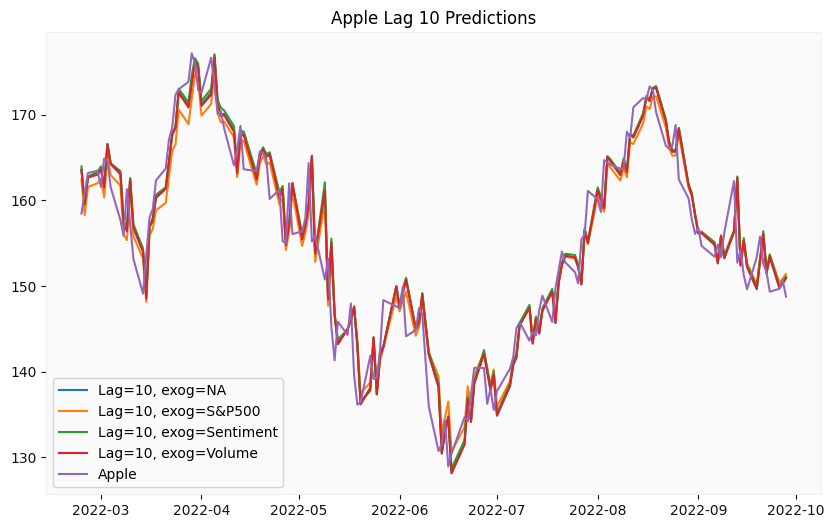

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
nrow = res_df.shape[0]
actual_close_prices_aapl = aapl['Close'][-nrow:]

plt.plot(res_df['Apple AR lag_10'], label='Lag=10, exog=NA')
plt.plot(res_df['Apple S&P 500 lag_10'], label='Lag=10, exog=S&P500')
plt.plot(res_df['Apple Sentiment lag_10'], label='Lag=10, exog=Sentiment')
plt.plot(res_df['Apple Volume lag_10'], label='Lag=10, exog=Volume')
plt.plot(actual_close_prices_aapl, label='Apple')
plt.title("Apple Lag 10 Predictions")
plt.legend()
plt.grid(False)
plt.show()

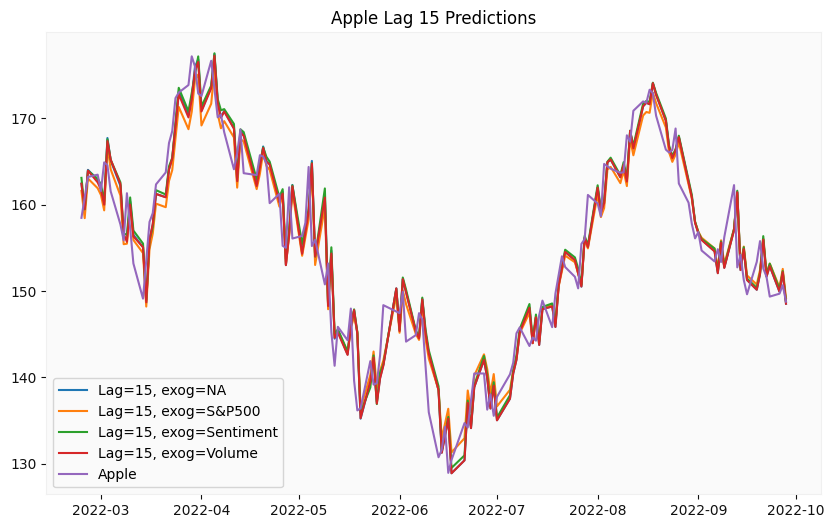

In [38]:
plt.figure(figsize=(10, 6))

plt.plot(res_df['Apple AR lag_15'], label='Lag=15, exog=NA')
plt.plot(res_df['Apple S&P 500 lag_15'], label='Lag=15, exog=S&P500')
plt.plot(res_df['Apple Sentiment lag_15'], label='Lag=15, exog=Sentiment')
plt.plot(res_df['Apple Volume lag_15'], label='Lag=15, exog=Volume')
plt.plot(actual_close_prices_aapl, label='Apple')
plt.title("Apple Lag 15 Predictions")
plt.legend()
plt.grid(False)
plt.show()

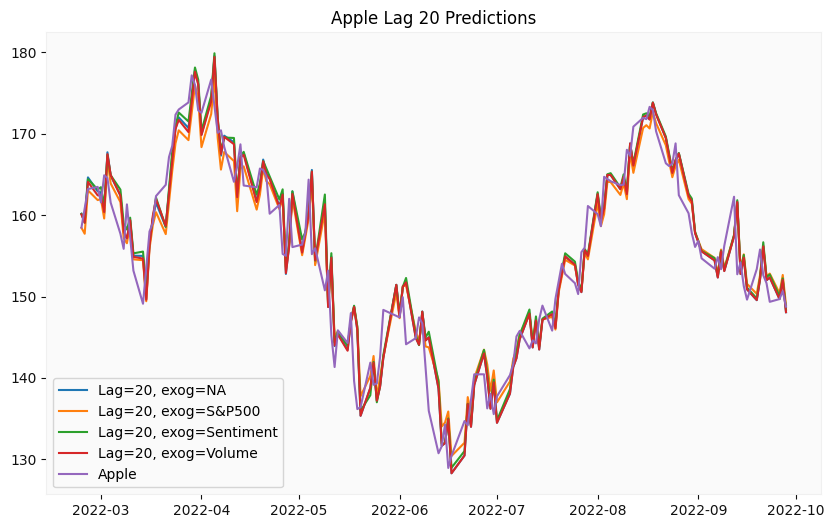

In [39]:
plt.figure(figsize=(10, 6))

plt.plot(res_df['Apple AR lag_20'], label='Lag=20, exog=NA')
plt.plot(res_df['Apple S&P 500 lag_20'], label='Lag=20, exog=S&P500')
plt.plot(res_df['Apple Sentiment lag_20'], label='Lag=20, exog=Sentiment')
plt.plot(res_df['Apple Volume lag_20'], label='Lag=20, exog=Volume')
plt.plot(actual_close_prices_aapl, label='Apple')
plt.title("Apple Lag 20 Predictions")
plt.legend()
plt.grid(False)
plt.show()

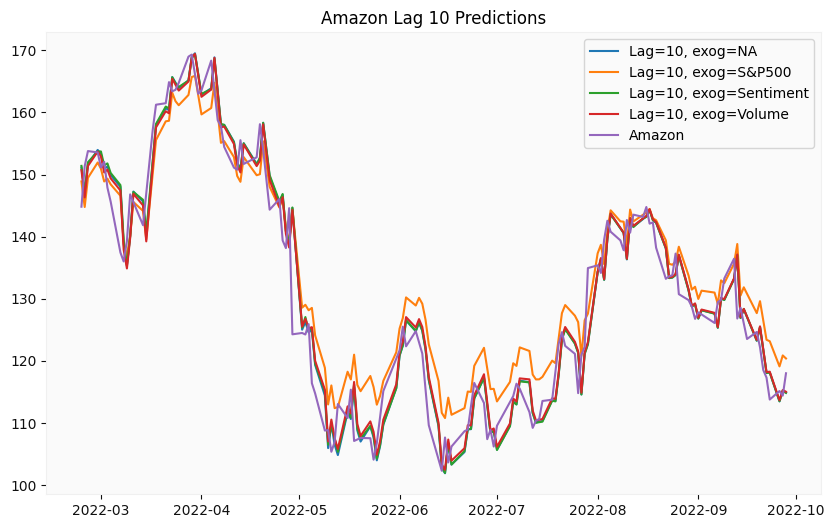

In [40]:
plt.figure(figsize=(10, 6))
nrow = res_df.shape[0]
actual_close_prices_amzn = amzn['Close'][-nrow:]

plt.plot(res_df['Amazon AR lag_10'], label='Lag=10, exog=NA')
plt.plot(res_df['Amazon S&P 500 lag_10'], label='Lag=10, exog=S&P500')
plt.plot(res_df['Amazon Sentiment lag_10'], label='Lag=10, exog=Sentiment')
plt.plot(res_df['Amazon Volume lag_10'], label='Lag=10, exog=Volume')
plt.plot(actual_close_prices_amzn, label='Amazon')
plt.title("Amazon Lag 10 Predictions")
plt.legend()
plt.grid(False)
plt.show()

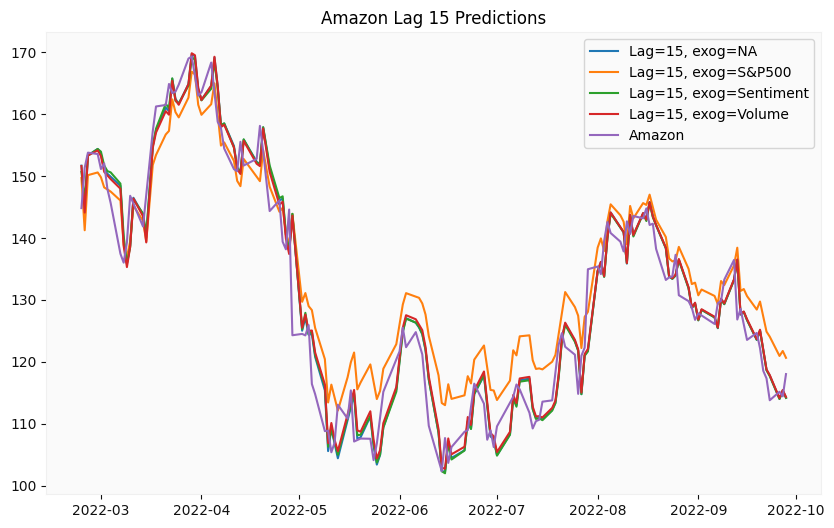

In [41]:
plt.figure(figsize=(10, 6))

plt.plot(res_df['Amazon AR lag_15'], label='Lag=15, exog=NA')
plt.plot(res_df['Amazon S&P 500 lag_15'], label='Lag=15, exog=S&P500')
plt.plot(res_df['Amazon Sentiment lag_15'], label='Lag=15, exog=Sentiment')
plt.plot(res_df['Amazon Volume lag_15'], label='Lag=15, exog=Volume')
plt.plot(actual_close_prices_amzn, label='Amazon')
plt.title("Amazon Lag 15 Predictions")
plt.legend()
plt.grid(False)
plt.show()

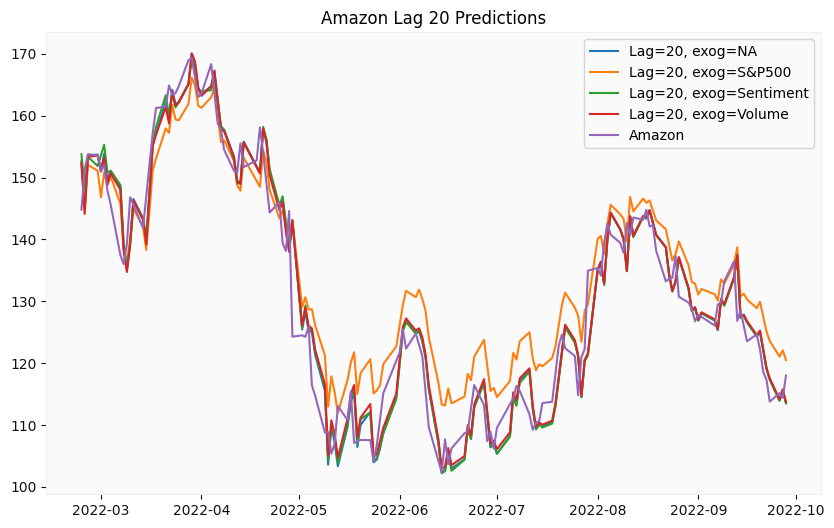

In [42]:
plt.figure(figsize=(10, 6))

plt.plot(res_df['Amazon AR lag_20'], label='Lag=20, exog=NA')
plt.plot(res_df['Amazon S&P 500 lag_20'], label='Lag=20, exog=S&P500')
plt.plot(res_df['Amazon Sentiment lag_20'], label='Lag=20, exog=Sentiment')
plt.plot(res_df['Amazon Volume lag_20'], label='Lag=20, exog=Volume')
plt.plot(actual_close_prices_amzn, label='Amazon')
plt.title("Amazon Lag 20 Predictions")
plt.legend()
plt.grid(False)
plt.show()

In [43]:
res_df.describe()

,Apple S&P 500 lag_10,Apple Volume lag_10,Apple Sentiment lag_10,Apple AR lag_10,Amazon Sentiment lag_10,Amazon Volume lag_10,Amazon S&P 500 lag_10,Amazon AR lag_10,Apple S&P 500 lag_15,Apple Volume lag_15,...,Amazon S&P 500 lag_15,Amazon AR lag_15,Apple S&P 500 lag_20,Apple Volume lag_20,Apple Sentiment lag_20,Apple AR lag_20,Amazon Sentiment lag_20,Amazon Volume lag_20,Amazon S&P 500 lag_20,Amazon AR lag_20
count,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,...,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000
mean,155.052460,155.405604,155.670369,155.420163,131.442215,131.507332,133.959173,131.368540,155.046626,155.277429,...,134.518636,131.396443,155.154946,155.368679,155.742450,155.410010,131.239186,131.373920,134.848229,131.176174
std,10.487162,11.179685,11.219278,11.209163,18.514043,18.170415,14.983083,18.541311,10.560306,11.258963,...,14.375782,18.512029,10.399250,11.274726,11.319870,11.309177,18.578648,18.209793,14.305717,18.571821
min,130.651565,128.164350,128.701159,128.151861,101.964101,102.458670,110.799971,101.909135,131.310914,128.892105,...,112.112907,102.225724,130.416126,128.288900,128.971147,128.290512,102.198180,102.830079,111.950791,102.278499
25%,147.147554,147.295822,147.436378,147.306563,114.942652,115.175511,120.604476,114.743867,146.996981,147.362204,...,121.617186,114.758852,147.259249,147.298080,147.742896,147.301071,114.472340,115.179206,121.925736,114.657761
50%,155.901956,156.160792,156.287026,156.150425,128.157469,128.269120,131.310503,128.158307,155.469928,155.908484,...,131.669830,128.020967,155.763027,155.559978,155.846418,155.570888,128.083617,128.222737,131.897157,128.059642
75%,162.843211,164.451736,164.531166,164.404782,146.410605,145.487337,144.734455,146.109765,163.296418,164.076425,...,145.386244,145.928373,162.766440,163.696804,164.144097,163.924948,145.868468,144.740923,145.652318,145.099555
max,175.483324,176.665953,177.048422,176.957634,169.361552,169.421494,165.898244,169.530521,175.698746,177.226295,...,166.873138,169.738594,176.990168,179.413650,179.872107,179.524071,169.156895,170.098083,166.137076,170.001542


# Bokeh

In [44]:
from bokeh.models.sources import ColumnarDataSource
from pandas.core.indexes.datetimes import date_range
from bokeh.io.output import output_file
from bokeh.plotting import figure, show, output_file
from bokeh.layouts import column, row
from bokeh.models import ColumnDataSource, Slider, CustomJS, DateRangeSlider, CheckboxGroup
import numpy as np
from bokeh.io import reset_output, output_notebook, show, output_file
from datetime import date
from bokeh.io.saving import save

In [51]:
reset_output()
output_notebook()

num_of_preds = res_df.shape[0]


unified_source = ColumnDataSource(data=dict(Date=aapl.iloc[-num_of_preds:].index,\
                                            Apple=aapl.Close.iloc[-num_of_preds:],\
                                            aapl_sp500_lag10 = res_df['Apple S&P 500 lag_10'],\
                                            aapl_ar_lag10 = res_df['Apple AR lag_10'],\
                                            aapl_vol_lag10 = res_df['Apple Volume lag_10'],\
                                            aapl_sent_lag10 = res_df['Apple Sentiment lag_10'],\
                                            aapl_sp500_lag15 = res_df['Apple S&P 500 lag_15'],\
                                            aapl_ar_lag15 = res_df['Apple AR lag_15'],\
                                            aapl_vol_lag15 = res_df['Apple Volume lag_15'],\
                                            aapl_sent_lag15 = res_df['Apple Sentiment lag_15'],\
                                            aapl_sp500_lag20 = res_df['Apple S&P 500 lag_20'],\
                                            aapl_ar_lag20 = res_df['Apple AR lag_20'],\
                                            aapl_vol_lag20 = res_df['Apple Volume lag_20'],\
                                            aapl_sent_lag20 = res_df['Apple Sentiment lag_20'],\
                                            Amazon=amzn.Close.iloc[-num_of_preds:],\
                                            amzn_sp500_lag10 = res_df['Amazon S&P 500 lag_10'],\
                                            amzn_ar_lag10 = res_df['Amazon AR lag_10'],\
                                            amzn_vol_lag10 = res_df['Amazon Volume lag_10'],\
                                            amzn_sent_lag10 = res_df['Amazon Sentiment lag_10'],\
                                            amzn_sp500_lag15 = res_df['Amazon S&P 500 lag_15'],\
                                            amzn_ar_lag15 = res_df['Amazon AR lag_15'],\
                                            amzn_vol_lag15 = res_df['Amazon Volume lag_15'],\
                                            amzn_sent_lag15 = res_df['Amazon Sentiment lag_15'],\
                                            amzn_sp500_lag20 = res_df['Amazon S&P 500 lag_20'],\
                                            amzn_ar_lag20 = res_df['Amazon AR lag_20'],\
                                            amzn_vol_lag20 = res_df['Amazon Volume lag_20'],\
                                            amzn_sent_lag20 = res_df['Amazon Sentiment lag_20']))

backup = ColumnDataSource(data=dict(Date=aapl.iloc[-num_of_preds:].index,\
                                            Apple=aapl.Close.iloc[-num_of_preds:],\
                                            aapl_sp500_lag10 = res_df['Apple S&P 500 lag_10'],\
                                            aapl_ar_lag10 = res_df['Apple AR lag_10'],\
                                            aapl_vol_lag10 = res_df['Apple Volume lag_10'],\
                                            aapl_sent_lag10 = res_df['Apple Sentiment lag_10'],\
                                            aapl_sp500_lag15 = res_df['Apple S&P 500 lag_15'],\
                                            aapl_ar_lag15 = res_df['Apple AR lag_15'],\
                                            aapl_vol_lag15 = res_df['Apple Volume lag_15'],\
                                            aapl_sent_lag15 = res_df['Apple Sentiment lag_15'],\
                                            aapl_sp500_lag20 = res_df['Apple S&P 500 lag_20'],\
                                            aapl_ar_lag20 = res_df['Apple AR lag_20'],\
                                            aapl_vol_lag20 = res_df['Apple Volume lag_20'],\
                                            aapl_sent_lag20 = res_df['Apple Sentiment lag_20'],\
                                            Amazon=amzn.Close.iloc[-num_of_preds:],\
                                            amzn_sp500_lag10 = res_df['Amazon S&P 500 lag_10'],\
                                            amzn_ar_lag10 = res_df['Amazon AR lag_10'],\
                                            amzn_vol_lag10 = res_df['Amazon Volume lag_10'],\
                                            amzn_sent_lag10 = res_df['Amazon Sentiment lag_10'],\
                                            amzn_sp500_lag15 = res_df['Amazon S&P 500 lag_15'],\
                                            amzn_ar_lag15 = res_df['Amazon AR lag_15'],\
                                            amzn_vol_lag15 = res_df['Amazon Volume lag_15'],\
                                            amzn_sent_lag15 = res_df['Amazon Sentiment lag_15'],\
                                            amzn_sp500_lag20 = res_df['Amazon S&P 500 lag_20'],\
                                            amzn_ar_lag20 = res_df['Amazon AR lag_20'],\
                                            amzn_vol_lag20 = res_df['Amazon Volume lag_20'],\
                                            amzn_sent_lag20 = res_df['Amazon Sentiment lag_20']))

p = figure(x_axis_type='datetime', width=1000, height=600)

p.background_fill_color = "#f4f4f4"  # light grey background
p.border_fill_color = "#f4f4f4"        # dark grey for axes
p.xgrid.grid_line_alpha=0.5
p.ygrid.grid_line_alpha=0.5
p.xaxis.axis_label = 'Time'
p.yaxis.axis_label = 'Price'



aapl_line = p.line('Date', 'Apple',  source=unified_source, legend_label='AAPL', line_width=2, color='blue', visible=True)
aapl_sp500_lag10_line = p.line('Date', 'aapl_sp500_lag10',  source=unified_source, color='darkblue', line_width=2, visible=False)
aapl_ar_lag10_line = p.line('Date', 'aapl_ar_lag10',  source=unified_source, color='lightblue', line_width=2, visible=False)
aapl_vol_lag10_line = p.line('Date', 'aapl_vol_lag10',  source=unified_source, color='purple', line_width=2, visible=False)
aapl_sent_lag10_line = p.line('Date', 'aapl_sent_lag10',  source=unified_source, color='cyan', line_width=2, visible=False)
aapl_sp500_lag15_line = p.line('Date', 'aapl_sp500_lag15',  source=unified_source, color='darkblue', line_width=2, visible=False)
aapl_ar_lag15_line = p.line('Date', 'aapl_ar_lag15',  source=unified_source, line_width=2, color='lightblue', visible=False)
aapl_vol_lag15_line = p.line('Date', 'aapl_vol_lag15',  source=unified_source, line_width=2, color='purple', visible=False)
aapl_sent_lag15_line = p.line('Date', 'aapl_sent_lag15',  source=unified_source, line_width=2, color='cyan', visible=False)
aapl_sp500_lag20_line = p.line('Date', 'aapl_sp500_lag20',  source=unified_source, line_width=2, color='darkblue', visible=False)
aapl_ar_lag20_line = p.line('Date', 'aapl_ar_lag20',  source=unified_source, line_width=2, color='lightblue', visible=False)
aapl_vol_lag20_line = p.line('Date', 'aapl_vol_lag20',  source=unified_source, line_width=2, color='purple', visible=False)
aapl_sent_lag20_line = p.line('Date', 'aapl_sent_lag20',  source=unified_source, line_width=2, color='cyan', visible=False)

amzn_line = p.line('Date', 'Amazon', source=unified_source, legend_label='AMZN', line_width=2, color='red', visible=True)
amzn_sp500_lag10_line = p.line('Date', 'amzn_sp500_lag10',  source=unified_source, color='darkred', line_width=2, visible=False)
amzn_ar_lag10_line = p.line('Date', 'amzn_ar_lag10',  source=unified_source, line_width=2, color='plum', visible=False)
amzn_vol_lag10_line = p.line('Date', 'amzn_vol_lag10',  source=unified_source, line_width=2, color='orange', visible=False)
amzn_sent_lag10_line = p.line('Date', 'amzn_sent_lag10',  source=unified_source, line_width=2, color='coral', visible=False)
amzn_sp500_lag15_line = p.line('Date', 'amzn_sp500_lag15',  source=unified_source, line_width=2, color='darkred', visible=False)
amzn_ar_lag15_line = p.line('Date', 'amzn_ar_lag15',  source=unified_source, color='plum', line_width=2, visible=False)
amzn_vol_lag15_line = p.line('Date', 'amzn_vol_lag15',  source=unified_source, color='orange', line_width=2, visible=False)
amzn_sent_lag15_line = p.line('Date', 'amzn_sent_lag15',  source=unified_source, color='coral', line_width=2, visible=False)
amzn_sp500_lag20_line = p.line('Date', 'amzn_sp500_lag20',  source=unified_source, color='darkred', line_width=2, visible=False)
amzn_ar_lag20_line = p.line('Date', 'amzn_ar_lag20',  source=unified_source, color='plum', line_width=2, visible=False)
amzn_vol_lag20_line = p.line('Date', 'amzn_vol_lag20',  source=unified_source, color='orange', line_width=2, visible=False)
amzn_sent_lag20_line = p.line('Date', 'amzn_sent_lag20',  source=unified_source, color='coral', line_width=2, visible=False)

# date range slider
date_range_slider = DateRangeSlider(value=(date(2022, 2, 23), date(2022, 9, 27)),
                                    start=date(2022, 2, 23), end=date(2022, 9, 27))

labels = ["AAPL", "AMZN", "AAPL Exog=NA, Lag=10", "AAPL Exog=S&P 500, Lag=10", "AAPL Exog=Volume, Lag=10", "AAPL Exog=Sentiment, Lag=10", \
          "AAPL Exog=NA, Lag=15", "AAPL Exog=S&P 500, Lag=15", "AAPL Exog=Volume, Lag=15", "AAPL Exog=Sentiment, Lag=15", \
          "AAPL Exog=NA, Lag=20", "AAPL Exog=S&P 500, Lag=20", "AAPL Exog=Volume, Lag=20", "AAPL Exog=Sentiment, Lag=20", \
          "AMZN Exog=NA, Lag=10", "AMZN Exog=S&P 500, Lag=10", "AMZN Exog=Volume, Lag=10", "AMZN Exog=Sentiment, Lag=10", \
          "AMZN Exog=NA, Lag=15", "AMZN Exog=S&P 500, Lag=15", "AMZN Exog=Volume, Lag=15", "AMZN Exog=Sentiment, Lag=15", \
          "AMZN Exog=NA, Lag=20", "AMZN Exog=S&P 500, Lag=20", "AMZN Exog=Volume, Lag=20", "AMZN Exog=Sentiment, Lag=20"]
checkbox_group = CheckboxGroup(labels=labels, active=[0, 1])

# Adding callback for date range slider
inputs = dict(source=unified_source, backup=backup, slider=date_range_slider, checkbox=checkbox_group, aapl_line = aapl_line, amzn_line = amzn_line, aapl_ar_lag10_line = aapl_ar_lag10_line, \
              aapl_sp500_lag10_line = aapl_sp500_lag10_line, aapl_vol_lag10_line = aapl_vol_lag10_line, aapl_sent_lag10_line = aapl_sent_lag10_line, \
              aapl_ar_lag15_line = aapl_ar_lag15_line, aapl_sp500_lag15_line = aapl_sp500_lag15_line, aapl_vol_lag15_line = aapl_vol_lag15_line, \
              aapl_sent_lag15_line = aapl_sent_lag15_line, aapl_ar_lag20_line = aapl_ar_lag20_line, aapl_sp500_lag20_line = aapl_sp500_lag20_line, \
              aapl_vol_lag20_line = aapl_vol_lag20_line, aapl_sent_lag20_line = aapl_sent_lag20_line, amzn_ar_lag10_line = amzn_ar_lag10_line, \
              amzn_sp500_lag10_line = amzn_sp500_lag10_line, amzn_vol_lag10_line = amzn_vol_lag10_line, amzn_sent_lag10_line = amzn_sent_lag10_line, \
              amzn_ar_lag15_line = amzn_ar_lag15_line, amzn_sp500_lag15_line = amzn_sp500_lag15_line, amzn_vol_lag15_line = amzn_vol_lag15_line, \
              amzn_sent_lag15_line = amzn_sent_lag15_line, amzn_ar_lag20_line = amzn_ar_lag20_line, amzn_sp500_lag20_line = amzn_sp500_lag20_line, \
              amzn_vol_lag20_line = amzn_vol_lag20_line, amzn_sent_lag20_line = amzn_sent_lag20_line)

slider_callback = CustomJS(args=inputs,
                    code="""

    var selected_checkboxes = checkbox.active;

    // Get the data source of the plot
    var aapl  = backup.data.Apple;
    var amzn  = backup.data.Amazon;
    var aapl_ar_lag10 = backup.data.aapl_ar_lag10;
    var aapl_sp500_lag10 = backup.data.aapl_sp500_lag10;
    var aapl_vol_lag10 = backup.data.aapl_vol_lag10;
    var aapl_sent_lag10 = backup.data.aapl_sent_lag10;
    var aapl_ar_lag15 = backup.data.aapl_ar_lag15;
    var aapl_sp500_lag15 = backup.data.aapl_sp500_lag15;
    var aapl_vol_lag15 = backup.data.aapl_vol_lag15;
    var aapl_sent_lag15 = backup.data.aapl_sent_lag15;
    var aapl_ar_lag20 = backup.data.aapl_ar_lag20;
    var aapl_sp500_lag20 = backup.data.aapl_sp500_lag20;
    var aapl_vol_lag20 = backup.data.aapl_vol_lag20;
    var aapl_sent_lag20 = backup.data.aapl_sent_lag20;

    var amzn_ar_lag10 = backup.data.amzn_ar_lag10;
    var amzn_sp500_lag10 = backup.data.amzn_sp500_lag10;
    var amzn_vol_lag10 = backup.data.amzn_vol_lag10;
    var amzn_sent_lag10 = backup.data.amzn_sent_lag10;
    var amzn_ar_lag15 = backup.data.amzn_ar_lag15;
    var amzn_sp500_lag15 = backup.data.amzn_sp500_lag15;
    var amzn_vol_lag15 = backup.data.amzn_vol_lag15;
    var amzn_sent_lag15 = backup.data.amzn_sent_lag15;
    var amzn_ar_lag20 = backup.data.amzn_ar_lag20;
    var amzn_sp500_lag20 = backup.data.amzn_sp500_lag20;
    var amzn_vol_lag20 = backup.data.amzn_vol_lag20;
    var amzn_sent_lag20 = backup.data.amzn_sent_lag20;

    var date  = backup.data.Date;


    // Filter the data based on the selected date range
    var filtered_dates = [];

    var filtered_prices_aapl = [];
    var filtered_prices_amzn = [];
    var filtered_prices_aapl_ar_lag10 = [];
    var filtered_prices_aapl_sp500_lag10 = [];
    var filtered_prices_aapl_vol_lag10 = [];
    var filtered_prices_aapl_sent_lag10 = [];
    var filtered_prices_aapl_ar_lag15 = [];
    var filtered_prices_aapl_sp500_lag15 = [];
    var filtered_prices_aapl_vol_lag15 = [];
    var filtered_prices_aapl_sent_lag15 = [];
    var filtered_prices_aapl_ar_lag20 = [];
    var filtered_prices_aapl_sp500_lag20 = [];
    var filtered_prices_aapl_vol_lag20 = [];
    var filtered_prices_aapl_sent_lag20 = [];
    var filtered_prices_amzn_ar_lag10 = [];
    var filtered_prices_amzn_sp500_lag10 = [];
    var filtered_prices_amzn_vol_lag10 = [];
    var filtered_prices_amzn_sent_lag10 = [];
    var filtered_prices_amzn_ar_lag15 = [];
    var filtered_prices_amzn_sp500_lag15 = [];
    var filtered_prices_amzn_vol_lag15 = [];
    var filtered_prices_amzn_sent_lag15 = [];
    var filtered_prices_amzn_ar_lag20 = [];
    var filtered_prices_amzn_sp500_lag20 = [];
    var filtered_prices_amzn_vol_lag20 = [];
    var filtered_prices_amzn_sent_lag20 = [];

    for (var i = 0; i < date.length; i++) {
        if ((date[i] >= slider.value[0]) && (date[i] <= slider.value[1])) {
          filtered_dates.push(date[i])
          filtered_prices_aapl.push(aapl[i]);
          filtered_prices_amzn.push(amzn[i]);
          filtered_prices_aapl_ar_lag10.push(aapl_ar_lag10[i]);
          filtered_prices_aapl_sp500_lag10.push(aapl_sp500_lag10[i]);
          filtered_prices_aapl_vol_lag10.push(aapl_vol_lag10[i]);
          filtered_prices_aapl_sent_lag10.push(aapl_sent_lag10[i]);
          filtered_prices_aapl_ar_lag15.push(aapl_ar_lag15[i]);
          filtered_prices_aapl_sp500_lag15.push(aapl_sp500_lag15[i]);
          filtered_prices_aapl_vol_lag15.push(aapl_vol_lag15[i]);
          filtered_prices_aapl_sent_lag15.push(aapl_sent_lag15[i]);
          filtered_prices_aapl_ar_lag20.push(aapl_ar_lag20[i]);
          filtered_prices_aapl_sp500_lag20.push(aapl_sp500_lag20[i]);
          filtered_prices_aapl_vol_lag20.push(aapl_vol_lag20[i]);
          filtered_prices_aapl_sent_lag20.push(aapl_sent_lag20[i]);
          filtered_prices_amzn_ar_lag10.push(amzn_ar_lag10[i]);
          filtered_prices_amzn_sp500_lag10.push(amzn_sp500_lag10[i]);
          filtered_prices_amzn_vol_lag10.push(amzn_vol_lag10[i]);
          filtered_prices_amzn_sent_lag10.push(amzn_sent_lag10[i]);
          filtered_prices_amzn_ar_lag15.push(amzn_ar_lag15[i]);
          filtered_prices_amzn_sp500_lag15.push(amzn_sp500_lag15[i]);
          filtered_prices_amzn_vol_lag15.push(amzn_vol_lag15[i]);
          filtered_prices_amzn_sent_lag15.push(amzn_sent_lag15[i]);
          filtered_prices_amzn_ar_lag20.push(amzn_ar_lag20[i]);
          filtered_prices_amzn_sp500_lag20.push(amzn_sp500_lag20[i]);
          filtered_prices_amzn_vol_lag20.push(amzn_vol_lag20[i]);
          filtered_prices_amzn_sent_lag20.push(amzn_sent_lag20[i]);
        }
    }
    source.data['Apple']  = filtered_prices_aapl;
    source.data['Amazon']  = filtered_prices_amzn;
    source.data['aapl_ar_lag10']  = filtered_prices_aapl_ar_lag10;
    source.data['aapl_sp500_lag10']  = filtered_prices_aapl_sp500_lag10;
    source.data['aapl_vol_lag10']  = filtered_prices_aapl_vol_lag10;
    source.data['aapl_sent_lag10']  = filtered_prices_aapl_sent_lag10;
    source.data['aapl_ar_lag15']  = filtered_prices_aapl_ar_lag15;
    source.data['aapl_sp500_lag15']  = filtered_prices_aapl_sp500_lag15;
    source.data['aapl_vol_lag15']  = filtered_prices_aapl_vol_lag15;
    source.data['aapl_sent_lag15']  = filtered_prices_aapl_sent_lag15;
    source.data['aapl_ar_lag20']  = filtered_prices_aapl_ar_lag20;
    source.data['aapl_sp500_lag20']  = filtered_prices_aapl_sp500_lag20;
    source.data['aapl_vol_lag20']  = filtered_prices_aapl_vol_lag20;
    source.data['aapl_sent_lag20']  = filtered_prices_aapl_sent_lag20;
    source.data['amzn_ar_lag10']  = filtered_prices_amzn_ar_lag10;
    source.data['amzn_sp500_lag10']  = filtered_prices_amzn_sp500_lag10;
    source.data['amzn_vol_lag10']  = filtered_prices_amzn_vol_lag10;
    source.data['amzn_sent_lag10']  = filtered_prices_amzn_sent_lag10;
    source.data['amzn_ar_lag15']  = filtered_prices_amzn_ar_lag15;
    source.data['amzn_sp500_lag15']  = filtered_prices_amzn_sp500_lag15;
    source.data['amzn_vol_lag15']  = filtered_prices_amzn_vol_lag15;
    source.data['amzn_sent_lag15']  = filtered_prices_amzn_sent_lag15;
    source.data['amzn_ar_lag20']  = filtered_prices_amzn_ar_lag20;
    source.data['amzn_sp500_lag20']  = filtered_prices_amzn_sp500_lag20;
    source.data['amzn_vol_lag20']  = filtered_prices_amzn_vol_lag20;
    source.data['amzn_sent_lag20']  = filtered_prices_amzn_sent_lag20;

    if (selected_checkboxes.includes(0)) {
      aapl_line.visible = true;
    }
    else{
      aapl_line.visible = false;
    }
    if (selected_checkboxes.includes(1)) {
      amzn_line.visible = true;
    }
    else{
      amzn_line.visible = false;
    }
    if (selected_checkboxes.includes(2)) {
      aapl_ar_lag10_line.visible = true;
    }
    else{
      aapl_ar_lag10_line.visible = false;
    }
    if (selected_checkboxes.includes(3)) {
      aapl_sp500_lag10_line.visible = true;
    }
    else{
      aapl_sp500_lag10_line.visible = false;
    }
    if (selected_checkboxes.includes(4)) {
      aapl_vol_lag10_line.visible = true;
    }
    else{
      aapl_vol_lag10_line.visible = false;
    }
    if (selected_checkboxes.includes(5)) {
      aapl_sent_lag10_line.visible = true;
    }
    else{
      aapl_sent_lag10_line.visible = false;
    }
    if (selected_checkboxes.includes(6)) {
      aapl_ar_lag15_line.visible = true;
    }
    else{
      aapl_ar_lag15_line.visible = false;
    }
    if (selected_checkboxes.includes(7)) {
      aapl_sp500_lag15_line.visible = true;
    }
    else{
      aapl_sp500_lag15_line.visible = false;
    }
    if (selected_checkboxes.includes(8)) {
      aapl_vol_lag15_line.visible = true;
    }
    else{
      aapl_vol_lag15_line.visible = false;
    }
    if (selected_checkboxes.includes(9)) {
      aapl_sent_lag15_line.visible = true;
    }
    else{
      aapl_sent_lag15_line.visible = false;
    }
    if (selected_checkboxes.includes(10)) {
      aapl_ar_lag20_line.visible = true;
    }
    else{
      aapl_ar_lag20_line.visible = false;
    }
    if (selected_checkboxes.includes(11)) {
      aapl_sp500_lag20_line.visible = true;
    }
    else{
      aapl_sp500_lag20_line.visible = false;
    }
    if (selected_checkboxes.includes(12)) {
      aapl_vol_lag20_line.visible = true;
    }
    else{
      aapl_vol_lag20_line.visible = false;
    }
    if (selected_checkboxes.includes(13)) {
      aapl_sent_lag20_line.visible = true;
    }
    else{
      aapl_sent_lag20_line.visible = false;
    }
    if (selected_checkboxes.includes(14)) {
      amzn_ar_lag10_line.visible = true;
    }
    else{
      amzn_ar_lag10_line.visible = false;
    }
    if (selected_checkboxes.includes(15)) {
      amzn_sp500_lag10_line.visible = true;
    }
    else{
      amzn_sp500_lag10_line.visible = false;
    }
    if (selected_checkboxes.includes(16)) {
      amzn_vol_lag10_line.visible = true;
    }
    else{
      amzn_vol_lag10_line.visible = false;
    }
    if (selected_checkboxes.includes(17)) {
      amzn_sent_lag10_line.visible = true;
    }
    else{
      amzn_sent_lag10_line.visible = false;
    }
    if (selected_checkboxes.includes(18)) {
      amzn_ar_lag15_line.visible = true;
    }
    else{
      amzn_ar_lag15_line.visible = false;
    }
    if (selected_checkboxes.includes(19)) {
      amzn_sp500_lag15_line.visible = true;
    }
    else{
      amzn_sp500_lag15_line.visible = false;
    }
    if (selected_checkboxes.includes(20)) {
      amzn_vol_lag15_line.visible = true;
    }
    else{
      amzn_vol_lag15_line.visible = false;
    }
    if (selected_checkboxes.includes(21)) {
      amzn_sent_lag15_line.visible = true;
    }
    else{
      amzn_sent_lag15_line.visible = false;
    }
    if (selected_checkboxes.includes(22)) {
      amzn_ar_lag20_line.visible = true;
    }
    else{
      amzn_ar_lag20_line.visible = false;
    }
    if (selected_checkboxes.includes(23)) {
      amzn_sp500_lag20_line.visible = true;
    }
    else{
      amzn_sp500_lag20_line.visible = false;
    }
    if (selected_checkboxes.includes(24)) {
      amzn_vol_lag20_line.visible = true;
    }
    else{
      amzn_vol_lag20_line.visible = false;
    }
    if (selected_checkboxes.includes(25)) {
      amzn_sent_lag20_line.visible = true;
    }
    else{
      amzn_sent_lag20_line.visible = false;
    }

    source.data['Date']  = filtered_dates;
    // Trigger an update of the plot
    source.change.emit();
""")


date_range_slider.js_on_change("value", slider_callback)

checkbox_group.js_on_change("active", slider_callback)


control = column(date_range_slider, checkbox_group)

layout = row(control, p)
output_file('test.html')
show(layout)